In [18]:
from typing import Annotated , Sequence , TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph , END
from langgraph.prebuilt import ToolNode

In [19]:
load_dotenv(override=True)

True

In [20]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage] , add_messages]



@tool
def add(a: int , b:int):
    """This is an addition function that adds 2 numbers together"""

    return a+b

@tool
def subtract(a: int , b:int):
    """This is an subtraction function that subtracts two numbers"""
    return a-b

@tool
def multiply(a:int , b:int):
    """This is a function that multiplies two numbers together"""
    return a * b


In [21]:
tools = [add , subtract , multiply]

model = ChatOpenAI(model = 'gpt-4.1-nano').bind_tools(tools)

In [22]:
def model_call(state : AgentState) -> AgentState:
    system_prompt = SystemMessage(content='You are my AI assistant , please answer my query to the best of your ability')
    
    response = model.invoke([system_prompt] + state['messages'])
    return {'messages' : [response]}

In [23]:
def should_continue(state : AgentState):
    messages = state['messages']
    last_message = messages[-1]
    if not last_message.tool_calls:
        return 'end'
    else:
        return 'continue'


In [24]:
graph = StateGraph(AgentState)
graph.add_node('our_agent' , model_call)

In [25]:
tool_node = ToolNode(tools=tools)
graph.add_node('tools' , tool_node)

In [26]:
graph.set_entry_point('our_agent')

graph.add_conditional_edges(
    'our_agent',
    should_continue,
    {
        'continue' : 'tools',
        'end' : END
    },
)

graph.add_edge('tools' , 'our_agent')

app = graph.compile()

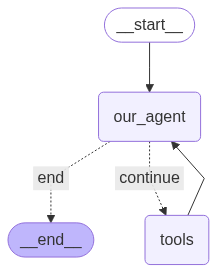

In [27]:
app

In [28]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]
        if isinstance(message,tuple):
            print(message)
        else:
            message.pretty_print()

In [29]:
inputs = {'messages' : [('user' , 'Add 3 + 4 and multiply 7 and 13')]}
print_stream(app.stream(inputs , stream_mode = 'values'))

================================ Human Message =================================

Add 3 + 4 and multiply 7 and 13
================================== Ai Message ==================================
Tool Calls:
  add (call_4r9DrlugsqGR3k7aWuZdlFyn)
 Call ID: call_4r9DrlugsqGR3k7aWuZdlFyn
  Args:
    a: 3
    b: 4
  multiply (call_ZnQbbfyZq9M3zWqAb6W1ItNL)
 Call ID: call_ZnQbbfyZq9M3zWqAb6W1ItNL
  Args:
    a: 7
    b: 13
================================= Tool Message =================================
Name: multiply

91
================================== Ai Message ==================================

The sum of 3 and 4 is 7, and the product of 7 and 13 is 91.
